In [1]:
import numpy as np
import matplotlib.dates
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

In [2]:
votes = pd.DataFrame()

In [3]:
votescsv = pd.read_csv('battleground-state-changes.csv')

In [4]:
#print(votescsv)

In [5]:
#take first word (ignore "(EV: X)")
votes['state'] = votescsv['state']
for i,row in votes.iterrows():
    row['state'] = row['state'].split()[0]

In [14]:
votes['timestamp'] = pd.to_datetime(votescsv['timestamp'],format='%Y-%m-%d %H:%M:%S.%f')

In [7]:
votes['biden']     = np.where(votescsv['leading_candidate_name']=='Biden',votescsv['leading_candidate_votes'],votescsv['trailing_candidate_votes'])
votes['trump']     = np.where(votescsv['leading_candidate_name']=='Trump',votescsv['leading_candidate_votes'],votescsv['trailing_candidate_votes'])

In [8]:
votes.sort_values(by='timestamp',inplace=True)

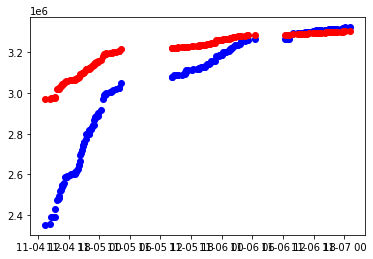

In [13]:
pen_df    = votes.query("state == 'Pennsylvania'",inplace=False)
pen_times = pen_df['timestamp'].dt.to_pydatetime()
pen_biden = pen_df['biden']
pen_trump = pen_df['trump']
plt.scatter(pen_times,pen_biden,c='b')
plt.scatter(pen_times,pen_trump,c='r')